# Spam Classifier Using SVM



## Environment Set Up

In [ ]:
!pip install utils

In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path_to_your_data = '/your_drive/data'
sys_path = os.path.join(prefix, '/your_drive/data')
sys.path.append(sys_path)

In [ ]:
# Import all the required modules here.
import os

import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import utils
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Enable auto reload
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Linear SVM 

In the first half, I will be using Support Vector Machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, we will be using support
vector machines to build a spam classifier.

In this part, I will try using different values of the $C$ parameter with SVMs. Informally, the $C$ parameter is a positive value that controls the penalty for misclassified training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

Specifically, I will train with `hinge_loss` and `l2` penalty, and **try 5 different $C$**, and plot them out.



In [ ]:
def plot_data(X, y, grid=False):
    
    pos = y == 1
    neg = y == 0
    
    # mew: marker edge width
    # mec: marker edge color
    # ms : marker size
    # mfc: marker face color
    plt.plot(X[pos, 0], X[pos, 1], 'X', mew=1, ms=10, mec='k')
    plt.plot(X[neg, 0], X[neg, 1], 'o', mew=1, mfc='y', ms=10, mec='k')
    
def plot_linear_boundary(X, y, model):

    w = model.coef_[0]    # The theta of your SVM classifier
    b = model.intercept_  # The bias of your SVM classifier
    xp = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
    yp = -(w[0] * xp + b) / w[1]
    
    plot_data(X, y)
    plt.plot(xp, yp)
    plt.show()
    
    
def plot_nonlinear_boundary(X, y, model):

    x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)
    x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), 100)
    X1, X2 = np.meshgrid(x1, x2)
    
    vals = np.zeros(X1.shape)

    for i in range(X1.shape[1]):
        X_ = np.stack((X1[:, i], X2[:, i]), axis=1)
        vals[:, i] = model.predict(X_)
    
    plt.contourf(X1, X2, vals, cmap='YlGnBu', alpha=0.2)    

    
    plot_data(X, y)
    plt.show()

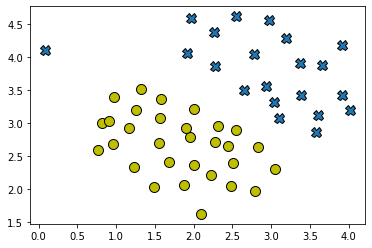

In [ ]:
# Load from ex6data1
# You will have X, y as keys in the dict data
data = loadmat(os.path.join(prefix,'/content/gdrive/MyDrive/Data/ex6data1.mat'))
X, y = data['X'], data['y'][:, 0]
# Plot training data
plot_data(X, y)

**Try 5 different C with Linear SVC. [10 pts]**

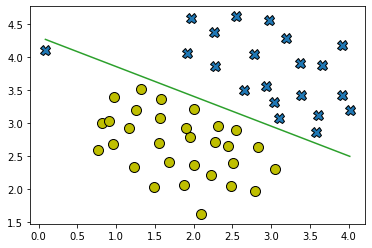

In [ ]:
# Try 5 different C with LinearSVC.
from sklearn.svm import LinearSVC
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=10)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

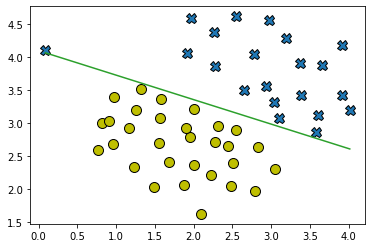

In [ ]:
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=20)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

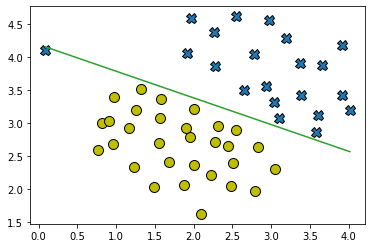

In [ ]:
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=30)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

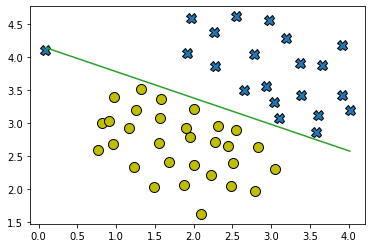

In [ ]:
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=50)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

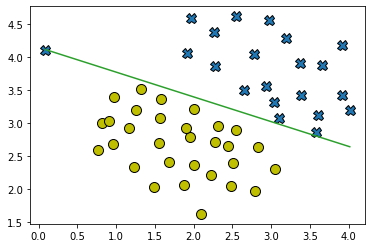

In [ ]:
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=70)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

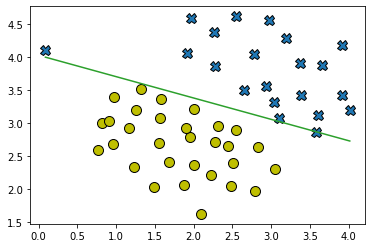

In [ ]:
svclassifier = LinearSVC(penalty='l2',loss='squared_hinge', C=1000)
svclassifier.fit(X, y)
svclassifier.predict(X)
plot_linear_boundary(X,y,svclassifier)

*   As value of C suggest SVM optmization to what extend it should misclassify training examples. For higher values of C we get smaller margin hyperplane and tried to reduce misclassification. While lower value of C increase the margin seperation of the hyperplane leading to at times more misclassification.

*   The outlier is strongly manipulating the hyperplane positions when the value of C is changed. When the value of C is increased the hyperplane margin is reduced and it tried hard to classify the outlier into relevant category. So, C, the outlier and hyperplane shares a mutual relationship.

## Kernel SVM


<a id="section1"></a>

### 1.2 SVM with Gaussian Kernels

In this part, I will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.

#### 1.2.1 Gaussian Kernel
In this section, our goal is to implement a Gaussian kernel for measuring the distance between a pair of examples ($x$, $l^{(i)}$):
$$ f_{(i)}=\text{similarity}\left( x, l^{(i)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x - l^{(i)} \right\lvert\right\lvert^2}{2\sigma^2} \right)$$
Where we pick $l^{(1)}=x^{(1)}$, $l^{(2)}=x^{(2)}$, $\cdots$, $l^{(m)}=x^{(m)}$, 

The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC
import sklearn

In [ ]:
def gaussian_kernel(x, l, sigma=2.0):

    f = np.zeros((x.shape[0], l.shape[0]))
    for i in range(x.shape[0]):
      for j in range(l.shape[0]):
        f[i][j] = np.exp(-np.square(np.linalg.norm(x[i]-l[j]))/(2*sigma**2))
    
    pass
    return f
    

In [ ]:
x1 = np.array([[1, 2, 1], [0, 4, -1]])
x2 = np.array([[1, 2, 1], [0, 4, -1]])
sigma = 2

sim = gaussian_kernel(x1, x2, sigma)
print(sim)

[[1.         0.32465247]
 [0.32465247 1.        ]]


Now, let's test it on the non-linear dataset:

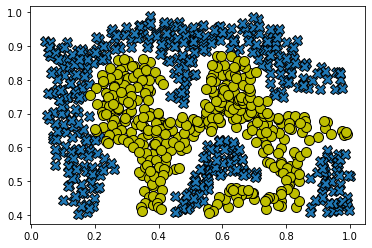

In [ ]:
# Load from ex6data2
# You will have X, y as keys in the dict data
data = loadmat(os.path.join(prefix, '/content/gdrive/MyDrive/Data/ex6data2.mat'))
X, y = data['X'], data['y'][:, 0]

# Plot training data
plot_data(X, y)

Now, Our task here is to train a SVM classifier with [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from `scikit-learn`.

While `SVC` has already implemented different kind of kernel functions, in this section, we need to use the `gaussian_kernel` that we just implemented, with `hinge_loss` and `l2` penalty.



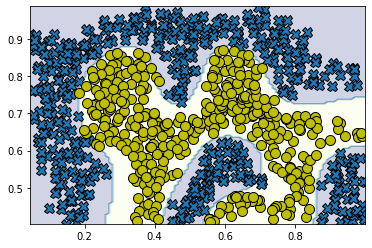

In [ ]:
from functools import partial
from sklearn.svm import SVC


def kernel_wrapper(kernel_func, sigma=0.1):
    def f(x, l):
        return kernel_func(x, l, sigma)
    return f
    
sigma = 0.1 
kernel_function = kernel_wrapper(gaussian_kernel, sigma=sigma)

model = SVC(C=1.0, kernel=kernel_function, random_state=5566)
model.fit(X, y)
plot_nonlinear_boundary(X, y, model)

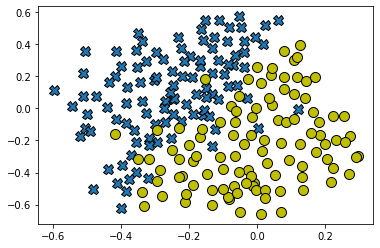

In [ ]:
# Load from ex6data3
# You will have X, y, Xval, yval as keys in the dict data
data = loadmat(os.path.join(prefix, '/content/gdrive/MyDrive/Data/ex6data3.mat'))

X_train = data['X']
y_train = data['y'][:, 0]
X_val = data['Xval']
y_val = data['yval'][:, 0]

# Plot training data
plot_data(X_train, y_train)

Our task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use. We will write any additional code necessary to help you search over the parameters $C$ and $\sigma$. For both $C$ and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).
Note that we should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if we try each of the 8 values listed above for $C$ and for $\sigma^2$, we would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. After we have determined the best $C$ and $\sigma$ parameters to use, we should modify the code in `search_hyperparam`, filling in the best parameters we found. For our best parameters, the SVM returned a decision boundary shown in the figure below. 

**Note that the best parameters may not be unique. We might get the same accuracy with a different decision boundary.**

In [ ]:
def evaluate_accuracy(y, y_pred):
    return np.mean(y == y_pred)

def search_hyperparam(X_train, y_train, X_val, y_val, Cs, sigmas):

    best_accuracy = 0
    for c in Cs:
      for s in sigmas:
        kernel_function = kernel_wrapper(gaussian_kernel, sigma=s)
        svc_model = SVC(C=c, kernel=kernel_function, random_state=5566)
        svc_model.fit(X_train, y_train)
        if svc_model.score(X_val, y_val)  > best_accuracy:
          best_accuracy = svc_model.score(X_val,y_val)
          best_C = c
          best_sigma = s
    return best_C, best_sigma, best_accuracy

**Trying different hyperparameters to train our SVM by using X_train, y_train, X_val and y_val.**

**Note that this might take a few minutes to execute.** 

In [ ]:

Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
sigmas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_C, best_sigma, best_accuracy = search_hyperparam(X_train, y_train, X_val, y_val, Cs, sigmas)
print(best_C,best_sigma,best_accuracy)

1 0.1 0.965


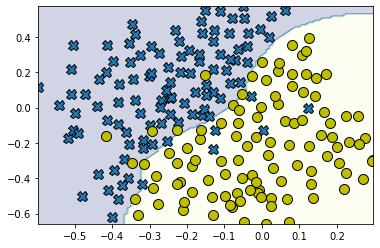

In [ ]:

kernel_function = kernel_wrapper(gaussian_kernel, sigma=best_sigma)
model = SVC(C=best_C, kernel=kernel_function)
model.fit(X_train, y_train)
plot_nonlinear_boundary(X_train, y_train, model)

<a id="section3"></a>
## Section 2 Spam Classification 

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part, we will use SVMs to build our own spam filter.

We will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). In particular, you need to convert each email into a feature vector $x \in \mathbb{R}^n$ . The following parts of the exercise will walk us through how such a feature vector can be constructed from an email.

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this, we will only be using the body of the email (excluding the email headers).

### 2.1 Preprocessing Emails

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every
email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the
email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small. 

In the function `process_email` below, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**:  All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

#### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the
model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

In [ ]:
def getVocabList():
    vocabList = np.genfromtxt(os.path.join(prefix,'/content/gdrive/MyDrive/Data/vocab.txt'), dtype=object)
    return list(vocabList[:, 1].astype(str))

In [ ]:
from nltk.stem import PorterStemmer
def process_email(email_contents, verbose=True):

    # Load Vocabulary
    vocabList = getVocabList()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================
    # Find the Headers ( \n\n and remove )
    # hdrstart = email_contents.find(chr(10) + chr(10))
    # email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()
    
    # Strip all HTML
    email_contents =re.compile('<[^<>]+>').sub(' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9
    email_contents = re.compile('[0-9]+').sub(' number ', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    email_contents = re.compile('(http|https)://[^\s]*').sub(' httpaddr ', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    email_contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', email_contents)
    
    # Handle $ sign
    email_contents = re.compile('[$]+').sub(' dollar ', email_contents)
    
    # get rid of any punctuation
    email_contents = re.split('[ @$/#.-:&*+=\[\]?!(){},''">_<;%\n\r]', email_contents)

    # remove any empty word string
    email_contents = [word for word in email_contents if len(word) > 0]
    
    # Stem the email contents word by word
    stemmer = PorterStemmer()
    processed_email = []
    
    for word in email_contents:
        # Remove any remaining non alphanumeric characters in word
        word = re.compile('[^a-zA-Z0-9]').sub('', word).strip()
        word = stemmer.stem(word)
        processed_email.append(word)

        if len(word) < 1:
            continue
        if word in vocabList:
          word_indices.append(vocabList.index(word))
        pass

    if verbose:
        print('----------------')
        print('Processed email:')
        print('----------------')
        print(' '.join(processed_email))
    return word_indices

In [ ]:
#  To use an SVM to classify emails into Spam v.s. Non-Spam, you first need
#  to convert each email into a vector of features. In this part, you will
#  implement the preprocessing steps for each email. You should
#  complete the code in processEmail.m to produce a word indices vector
#  for a given email.

# Extract Features
with open(os.path.join(prefix, '/content/gdrive/MyDrive/Data/spamSample1.txt')) as fid:
    file_contents = fid.read()

word_indices  = process_email(file_contents)

#Print Stats
print('-------------')
print('Word Indices:')
print('-------------')
print(word_indices)

----------------
Processed email:
----------------
do you want to make dollar number or more per week if you are a motiv and qualifi individu  i will person demonstr to you a system that will make you dollar number number per week or more thi is not mlm call our number hour prerecord number to get the detail number  number  number i need peopl who want to make seriou money make the call and get the fact invest number minut in yourself now number  number  number look forward to your call and i will introduc you to peopl like yourself who are current make dollar number number plu per week number  number  number number ljgv number  number lean number lrm number  number wxho number qiyt number  number rjuv number hqcf number  number eidb number dmtvl number
-------------
Word Indices:
-------------
[470, 1892, 1808, 1698, 996, 476, 1119, 1181, 1063, 1230, 1826, 809, 1892, 1069, 73, 1345, 836, 1851, 1241, 1698, 1892, 1630, 1664, 1851, 996, 1892, 476, 1119, 1119, 1230, 1826, 1181, 1063, 1675

<a id="section4"></a>
### 2.2 Extracting Features from Emails

We will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, we will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

In [ ]:
def email_features(word_indices):

    n = 1899
    x = np.zeros(n)

    for i in word_indices:
      x[i] = 1 
    return x

Once we have implemented `emailFeatures`, the next cell will run your code on the email sample. We should see that the feature vector had length 1899 and 45 non-zero entries.

In [ ]:
# Extract Features
with open(os.path.join(prefix,'/content/gdrive/MyDrive/Data/emailSample1.txt',)) as fid:
    file_contents = fid.read()

word_indices  = process_email(file_contents)
features      = email_features(word_indices)

# Print Stats
print('\nLength of feature vector: %d' % len(features))
print('Number of non-zero entries: %d' % sum(features > 0))

----------------
Processed email:
----------------
anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollar number you should checkout httpaddr or perhap amazon ec number if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr

Length of feature vector: 1899
Number of non-zero entries: 45


### 2.3 Training SVM for Spam Classification

In the following section we will load a preprocessed training dataset that will be used to train a SVM classifier. The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each
original email was processed using the `process_email` and `email_features` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

After loading the dataset, the next cell proceed to train a `LinearSVC` to classify between spam ($y = 1$) and non-spam ($y = 0$) emails.

In [ ]:
# Load the Spam Email dataset
# You will have X, y in your environment
data = loadmat(os.path.join(prefix, '/content/gdrive/MyDrive/Data/spamTrain.mat'))
X, y= data['X'].astype(float), data['y'][:, 0]

print('Training Linear SVM (Spam Classification)')

C = 0.1
model = LinearSVC(C=C, penalty='l2', loss='hinge', random_state=5566)
model.fit(X, y)
model.score(X,y)


Training Linear SVM (Spam Classification)


0.9985

In [ ]:
# Load the test dataset
# You will have Xtest, ytest in your environment
data = loadmat(os.path.join(prefix, '/content/gdrive/MyDrive/Data/spamTest.mat'))
Xtest, ytest = data['Xtest'].astype(float), data['ytest'][:, 0]

print('Evaluating the trained Linear SVM on a test set ...')
p = model.predict(Xtest)

print('Test Accuracy: %.2f' % (np.mean(p == ytest) * 100))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.90


### 2.4 Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell finds the parameters with the largest positive values in the classifier and displays the corresponding words similar to the ones shown in the figure below.

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.

In [ ]:
# Sort the weights and obtin the vocabulary list
# NOTE some words have the same weights, 
# so their order might be different than in the text above
weights = model.coef_[0]

idx = np.argsort(weights)
top_idx = idx[-15:][::-1]
vocabList = getVocabList()

print('Top predictors of spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for word, w in zip(np.array(vocabList)[top_idx], weights[top_idx]):
    print('%-15s %0.2f' % (word, w))


Top predictors of spam:
word            weight         
----            ------
our             0.50
click           0.47
remov           0.42
guarante        0.38
visit           0.37
basenumb        0.36
dollar          0.33
will            0.27
price           0.27
pleas           0.27
lo              0.26
nbsp            0.26
most            0.25
ga              0.25
hour            0.25


### 2.5 Try your own emails

Now that we have trained a spam classifier, we can start trying it out on your own emails. In the starter code, we have included two email examples (`emailSample1.txt` and `emailSample2.txt`) and two spam examples (`spamSample1.txt` and `spamSample2.txt`). The next cell runs the spam classifier over the first spam example and classifies it using the learned SVM. 


In [ ]:
filename = os.path.join(prefix,'/content/gdrive/MyDrive/Data/emailSample1.txt' )

with open(filename) as fid:
    file_contents = fid.read()

word_indices = process_email(file_contents, verbose=False)
x = email_features(word_indices)
print(x.shape)
p = model.predict(x.reshape(1, -1))

print('\nProcessed %s\nSpam Classification: %s' % (filename, 'spam' if p else 'not spam'))

(1899,)

Processed /content/gdrive/MyDrive/HW3/Data/emailSample1.txt
Spam Classification: not spam
